In [1]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")

In [2]:
import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
co2_data

,co2
date,
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-07-31,315.625000
1958-08-31,314.950000
...,...
2001-08-31,369.425000
2001-09-30,367.880000
2001-10-31,368.050000


In [18]:
#X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
#y = co2_data["co2"].to_numpy()
import pandas as pd

df_ = pd.read_csv(r"../data/co2_mm_mlo.csv", skiprows=56)
X = df_["decimal date"].to_numpy().reshape(-1, 1)
y = df_.average.to_numpy()

print(X)

[[1958.2027]
 [1958.2877]
 [1958.3699]
 [1958.4548]
 [1958.537 ]
 [1958.6219]
 [1958.7068]
 [1958.789 ]
 [1958.874 ]
 [1958.9562]
 [1959.0411]
 [1959.126 ]
 [1959.2027]
 [1959.2877]
 [1959.3699]
 [1959.4548]
 [1959.537 ]
 [1959.6219]
 [1959.7068]
 [1959.789 ]
 [1959.874 ]
 [1959.9562]
 [1960.041 ]
 [1960.1257]
 [1960.2049]
 [1960.2896]
 [1960.3716]
 [1960.4563]
 [1960.5383]
 [1960.623 ]
 [1960.7077]
 [1960.7896]
 [1960.8743]
 [1960.9563]
 [1961.0411]
 [1961.126 ]
 [1961.2027]
 [1961.2877]
 [1961.3699]
 [1961.4548]
 [1961.537 ]
 [1961.6219]
 [1961.7068]
 [1961.789 ]
 [1961.874 ]
 [1961.9562]
 [1962.0411]
 [1962.126 ]
 [1962.2027]
 [1962.2877]
 [1962.3699]
 [1962.4548]
 [1962.537 ]
 [1962.6219]
 [1962.7068]
 [1962.789 ]
 [1962.874 ]
 [1962.9562]
 [1963.0411]
 [1963.126 ]
 [1963.2027]
 [1963.2877]
 [1963.3699]
 [1963.4548]
 [1963.537 ]
 [1963.6219]
 [1963.7068]
 [1963.789 ]
 [1963.874 ]
 [1963.9562]
 [1964.041 ]
 [1964.1257]
 [1964.2049]
 [1964.2896]
 [1964.3716]
 [1964.4563]
 [1964.5383]

In [4]:
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor

kernel_ = 112**2 * Matern(length_scale=115, nu = 5/2) +\
          2.58**2 * Matern(length_scale=199, nu = 5/2) * ExpSineSquared(length_scale=1.36, periodicity=1, periodicity_bounds="fixed") +\
          0.575**2 * RationalQuadratic(alpha=0.672, length_scale=1.05) +\
          0.208**2 * Matern(length_scale=0.128, nu = 5/2) + WhiteKernel(noise_level=0.0382)

gpr = GaussianProcessRegressor(kernel=kernel_, optimizer=None)
y_mean = y.mean()
gpr.fit(X, y - y_mean)
gpr.kernel_

112**2 * Matern(length_scale=115, nu=2.5) + 2.58**2 * Matern(length_scale=199, nu=2.5) * ExpSineSquared(length_scale=1.36, periodicity=1) + 0.575**2 * RationalQuadratic(alpha=0.672, length_scale=1.05) + 0.208**2 * Matern(length_scale=0.128, nu=2.5) + WhiteKernel(noise_level=0.0382)

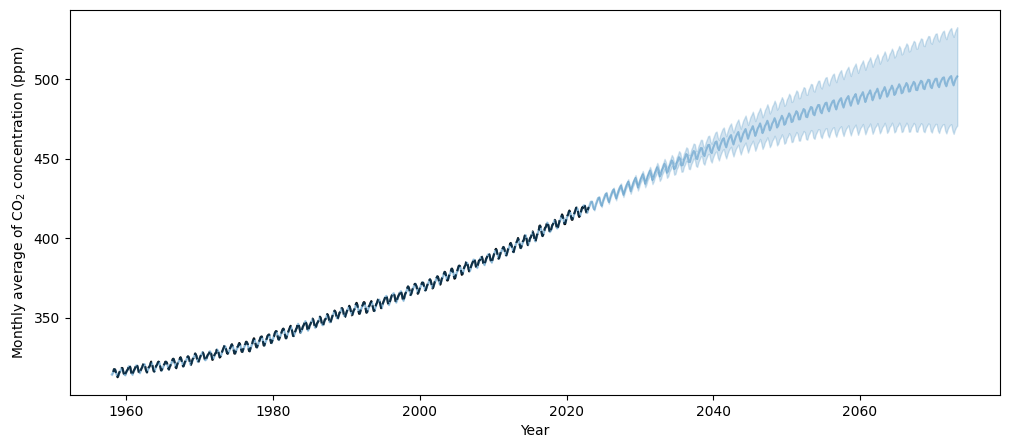

In [5]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

today = datetime.datetime.now()
current_month = today.year + 50 + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=700).reshape(-1, 1)

#y_samples = gpr.sample_y(X_test, 5)

mean_y_pred, std_y_pred = gpr.predict(X_test, return_std=True)
mean_y_pred += y_mean
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)

# for idx, single_prior in enumerate(y_samples.T):
#     plt.plot(
#         X_test, single_prior + y_mean
#         , alpha=.4, lw=1, linestyle="dashed"
#     )

plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
plt.show()

# BAND

In [8]:
%%capture
# Import my GP
%run ../GP.ipynb

In [40]:
X = jnp.array(X)
y = jnp.array(y)

def kernel_(theta, x__, y__):
    return (
            MaternKernel52(112 ** 2, 115, x__, y__)
            + MaternKernel52(2.58 ** 2, 199, x__, y__)
            * ExpSineSquaredKernel(1, 1.36, 1, x__, y__)
            + RationalQuadraticKernel(0.575 ** 2, 1.05, 0.672, x__, y__)
            + MaternKernel52(0.208 ** 2, 0.128, x__, y__)
    ) * WendlandTapering(3, theta, x__, y__)

y_mean = y.mean()
gpr = GPR(X, y - y_mean, kernel_, jnp.array([50]), eps = 0.0382)
#gpr.fit()

NMLL: 276.88904713366156


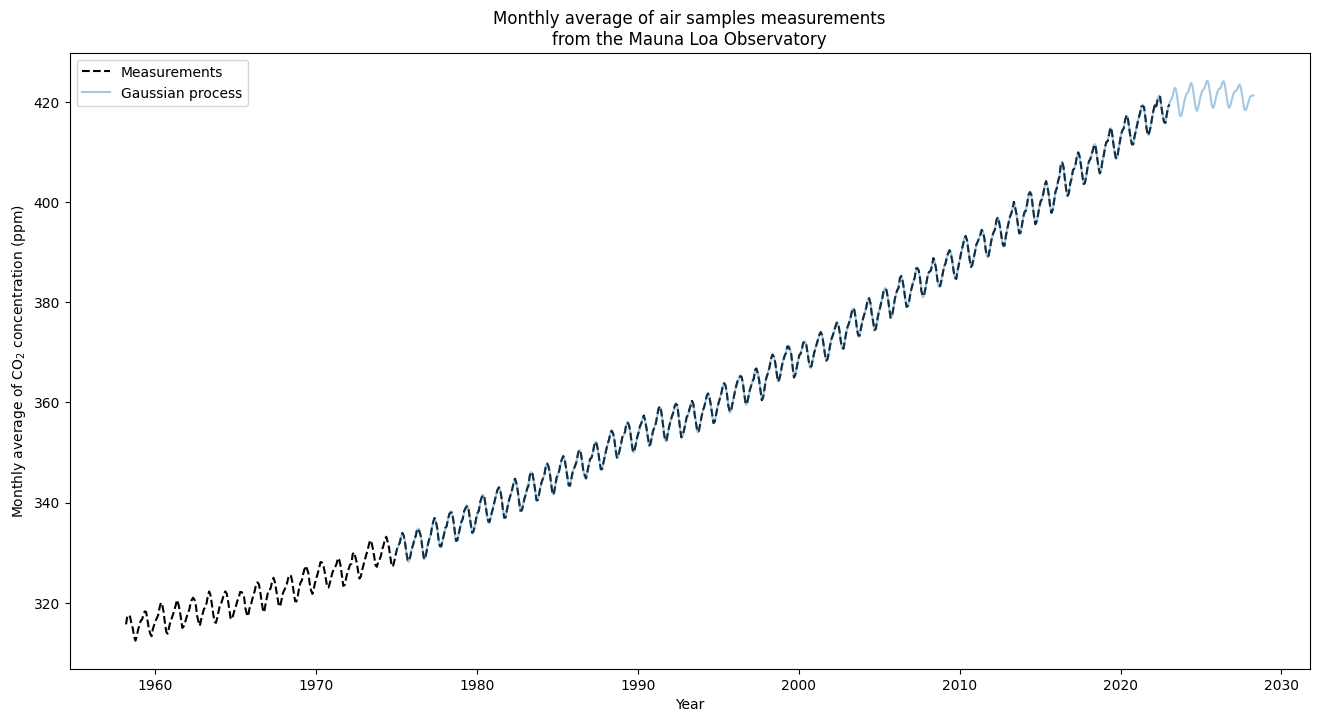

In [41]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

today = datetime.datetime.now()
current_month = today.year + 5 + today.month / 12
X_test = jnp.linspace(start=1975, stop=current_month, num=1_000).reshape(-1, 1)

mean_y_pred = gpr.predict(X_test, return_std=False)
mean_y_pred += y_mean
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test.ravel(), mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
# plt.fill_between(
#     X_test.ravel(),
#     mean_y_pred - std_y_pred,
#     mean_y_pred + std_y_pred,
#     color="tab:blue",
#     alpha=0.2,
# )
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)